Looking for C:\Users\markt\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\markt\.keras-ocr\crnn_kurapan.h5
..\img/Char
1/1 [==============================] - 0s 53ms/step
Already in dict
{'b': 'char_0.png', 'e': 'char_1.png', 'd': 'char_2.png', 'c': 'char_3.png', 'a': 'char_5.png', 'e0': 'char_7.png'}
The hamming distance between the two images is 28


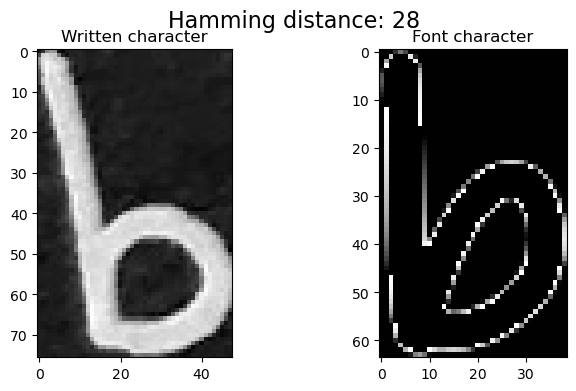

The hamming distance between the two images is 34


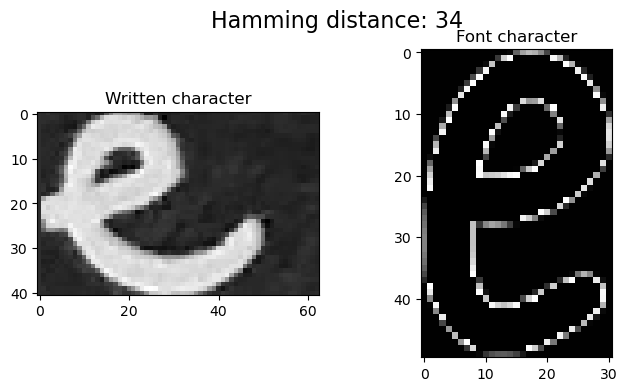

The hamming distance between the two images is 21


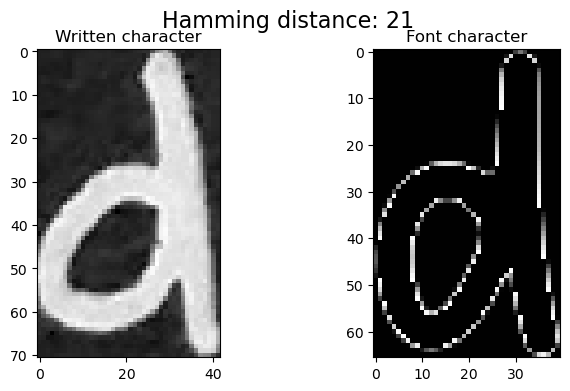

The hamming distance between the two images is 31


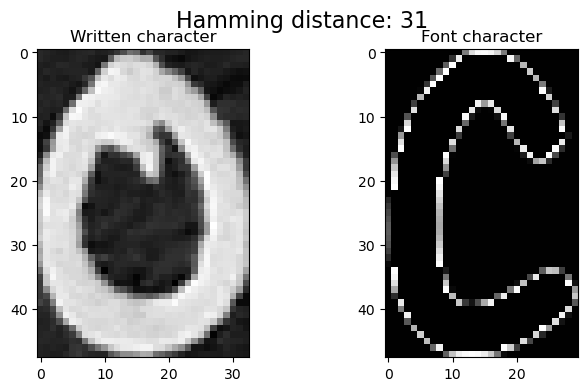

The hamming distance between the two images is 37


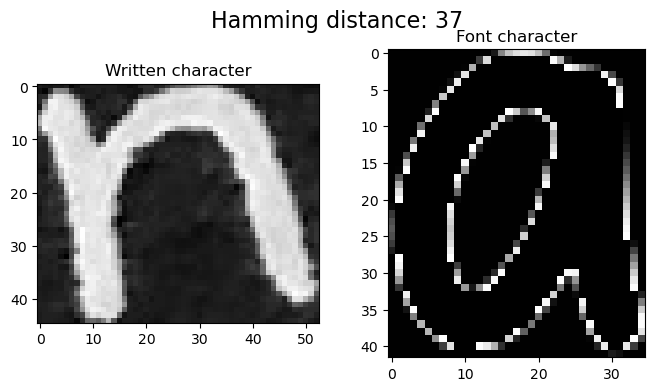

The hamming distance between the two images is 34


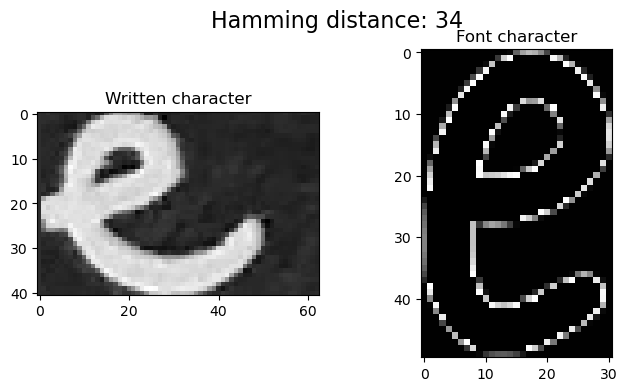

In [1]:
# Individual characters from image

import cv2
from imutils import contours
import tkinter as tk
from tkinter import ttk
import tkinter.filedialog
import numpy as np
from PIL import Image, ImageTk
import os
import keras_ocr
import os
import imagehash
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt

global besthamming
besthamming = 0
global avg_hamming
avg_hamming = 0

def get_char(file):
    
    filepath = os.path.abspath(file.name)
    # Load image
    image = cv2.imread(filepath)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Thresholded using Otsu's 
    # (Separates background from foreground i.e. create a binary image)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours, sort from left-to-right, then crop
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts, _ = contours.sort_contours(cnts, method="left-to-right")

    char_number = 0 # Assign number to each character
    for c in cnts: # For each contour (each character)
        area = cv2.contourArea(c) # Get area of contour
        if area > 100: # Area must be large enough to filter out noise
            x,y,w,h = cv2.boundingRect(c) # Get coordinates of character
            char = 255 - image[y:y+h, x:x+w] # Invert BW
            cv2.imwrite('img//char//char_{}.png'.format(char_number), char) # Save character as a PNG
            cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2) # Draw rectangle around character
            char_number += 1
    cv2.waitKey()
    identify_char()


# Identify characters from each image and map "character: filename" to a dictionary

def identify_char():
    pipeline = keras_ocr.pipeline.Pipeline() # Load OCR model
    path = os.path.join((os.pardir), "img/Char")##'C://Users//markt//Downloads//HandwritingML-main//HandwritingML-main//img//char'
    
                     # Dict stores "character: filename"
    files_and_chars = {} 
    # Iterate through each char image in path
    print(path)
    for filename in os.listdir(path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image = keras_ocr.tools.read(os.path.join(path, filename)) # Load image
            results = pipeline.recognize([image])                      # Recognize char in image

            # Extract recognized character and add to dict
            try:
                character = results[0][0][0]
                if character in files_and_chars:
                    print("Already in dict")
                    num = 0
                    while character in files_and_chars:
                        character += str(num)
                        num += 1
                    files_and_chars[character] = filename
                else:
                    files_and_chars[character] = filename
            except:
                continue
                
    print(files_and_chars)
    compare_char(files_and_chars)

# Compare handwritten characters from dictionary to font characters

def compare_char(files_and_chars):
    global avg_hamming
    global besthamming
    # Iterate through each char image in path
    for key, val in files_and_chars.items():
        written_path = os.path.join((os.pardir), "img/Char")
        written_path += ("/" + val)

        font_path = os.path.join((os.pardir), "fonts/hynings")          # Path to font images
        font_path += ("/" + key[0] + ".png") # Append filename to path

        written_char = io.imread(written_path, as_gray=True) # Handwritten character
        font_char    = io.imread(font_path, as_gray=True)    # Typed character

        # Convert NumPy arrays to PIL Image objects
        written_char = Image.fromarray((written_char * 255).astype('uint8'))
        font_char = Image.fromarray((font_char * 255).astype('uint8'))

        hash1 = imagehash.average_hash(written_char)
        hash2 = imagehash.average_hash(font_char)
        
        distance = hash1 - hash2
        avg_hamming = avg_hamming + distance
        
        #finding best Hamming
        if distance > besthamming:
            besthamming = distance
            best_written = written_char
            best_font = font_char
        print(f"The hamming distance between the two images is {distance}")

        # Plot the images and the hamming distance
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        ax1.imshow(written_char, cmap='gray')
        ax1.set_title('Written character')
        ax2.imshow(font_char, cmap='gray')
        ax2.set_title('Font character')
        plt.suptitle(f"Hamming distance: {distance}", fontsize=16)
        plt.show()
        
    #Saving Best Images to local directory
    best_written.save(os.path.join((os.pardir), "img/test/char_hand.png"))
    best_font.save(os.path.join((os.pardir), "img/test/char_font.png"))
    avg_hamming = avg_hamming / len(files_and_chars)
    with open(os.path.join((os.pardir), "img/test/test1.txt"), 'w') as resultFile:
        resultFile.write(f"{avg_hamming}")
    resultFile.close()
    with open(os.path.join((os.pardir), "img/test/test2.txt"), 'w') as resultFile:
        resultFile.write(f"{besthamming}")
    resultFile.close()
    return besthamming, avg_hamming

#function for taking in file to pass to analyzer functions
def open_file():
        file = tk.filedialog.askopenfile(filetypes =[('Image Files', '*.png'),('Image Files', '*.JPG')])
        get_char(file)
 
LARGEFONT =("Verdana", 35)

class MainApp(tk.Tk):
     
    # __init__ function for class tkinterApp
    def __init__(self, *args, **kwargs):
         
        # __init__ function for class Tk
        tk.Tk.__init__(self, *args, **kwargs)
         
        # creating a container
        container = tk.Frame(self) 
        container.pack(fill = "both", expand = True)
  
        container.grid_rowconfigure(0, weight = 1)
        container.grid_columnconfigure(0, weight = 1)
  
        # initializing frames to an empty array
        self.frames = {} 
  
        # iterating through a tuple consisting
        # of the different page layouts
        for F in (StartPage, Results):
  
            frame = F(container, self)
  
            # initializing frame of that object from
            # startpage, results respectively with
            # for loop
            self.frames[F] = frame
  
            frame.grid(row = 0, column = 0, sticky ="nsew")
  
        self.show_frame(StartPage)
  
    # to display the current frame passed as
    # parameter
    def show_frame(self, cont):
        frame = self.frames[cont]
        frame.tkraise()
 
  
# first window frame startpage
  
class StartPage(tk.Frame):
    global avg_hamming
    global besthamming
    
    def __init__(self, parent, controller):
        tk.Frame.__init__(self, parent)
        
        global avg_hamming
        global besthamming
        
        # label of frame Layout
        label = ttk.Label(self, text ="Handwriting Comparator", font = LARGEFONT)
        author = ttk.Label(self, text ="By Brent Melby, Joseph and Alex Robey")
        
        # putting the grid in its place by using
        # grid
        label.grid(row = 1, column = 2, padx = 10, pady = 10)
        author.grid(row = 2, column = 2, padx = 10, pady = 10)
        
        #Instructions for User
        greeting = tk.Label(self, text="Please Upload an image file containing the text you wish to compare(Acceptable formats are JPG, PNG, etc.)")
        greeting.grid(row = 3, column = 2, padx = 10, pady = 10)
  

        #File Explorer
        button1 = ttk.Button(self, text ="Open File",
        command = lambda : [self.open_file(), controller.show_frame(Results)])
        # putting the button in its place by
        # using grid
        button1.grid(row = 4, column = 2, padx = 10, pady = 10)
        
      
    def open_file(self):
        global avg_hamming
        global besthamming
        file = tk.filedialog.askopenfile(filetypes =[('Image Files', '*.png'),('Image Files', '*.JPG')])
        get_char(file)
  
# second window frame page1
class Results(tk.Frame):

    def __init__(self, parent, controller):
        
        #Page initializer
        tk.Frame.__init__(self, parent)
        label = ttk.Label(self, text ="Results", font = LARGEFONT)
        spacer = ttk.Label(self, text =" ", font = LARGEFONT)
        label.grid(row = 1, column = 3, pady = 10, columnspan = 3)
        spacer.grid(row = 1, column = 2, pady = 5)
        
        # Load the images using PIL
        imgFont = Image.open(os.path.join((os.pardir), "img//test//char_font.png"))

        # Convert the PIL images to PhotoImage
        photoChar = ImageTk.PhotoImage(file = (os.path.join((os.pardir), "img//test//char_hand.png")))
        photoFont = ImageTk.PhotoImage(file = (os.path.join((os.pardir), "img//test//char_font.png")))
        testfile1 = open (os.path.join((os.pardir), "img//test//test1.txt"), "r")
        avg_hamming = testfile1.read()
        testfile2 = open (os.path.join((os.pardir), "img//test//test2.txt"), "r")
        besthamming = testfile2.read()

        # Create the labels using PhotoImage
        imglabel1 = ttk.Label(self, image=photoChar)
        imglabel2 = ttk.Label(self, image=photoFont)
        #Setting labels to the converted photos
        imglabel1.image = photoChar
        imglabel2.image = photoFont
        #Setting labels in page grid
        imglabel1.grid(row = 2, column = 4, sticky="nsew")
        imglabel2.grid(row = 3, column = 4, sticky="nsew")
        
        
        #Scoring Results Display
        result1 = ttk.Label(self, text =f"Your Best Character:")
        result2 = ttk.Label(self, text =f"    The Closest Font Equivalent:")
        result3 = ttk.Label(self, text =f"Average Score: {float(avg_hamming):.3f} Best Score: {besthamming}")
        result4 = ttk.Label(self, text =f"Your handwriting on average, scored {float(avg_hamming):.3f} out of (TODO).\nWith your best score being {besthamming}")
        #return to menu button
        button1 = ttk.Button(self, text ="Return to Menu",
                            command = lambda : controller.show_frame(StartPage))

        result1.grid(row = 2, column = 3, padx = 10, pady = 5)
        result2.grid(row = 3, column = 3, padx = 10, pady = 5)
        result3.grid(row = 4, column = 3, padx = 10, pady = 5)
        result4.grid(row = 5, column = 3, padx = 5, pady = 5, sticky= "nsew")
        # putting the button in its place
        # by using grid
        button1.grid(row = 6, column = 3, padx = 10, pady = 10)

        
# Driver Code
app = MainApp()
app.title("Handwriting Comparator")
app.mainloop()